# Cervical Cancer prediction

#### Source - https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#



In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_curve, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance




## 1.a Load the data

In [89]:
def load_data(filepath):
    df = pd.read_csv(filepath, na_values='?')

    return df

In [90]:
file = 'risk_factors_cervical_cancer.csv'
pre_df = load_data(file)

## 1.b Data Exploration

In [91]:
pre_df.shape

(858, 36)

In [51]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

In [52]:
# count missing values

print("Total missing values ", pre_df.isnull().sum().sum())
print("Percent values missing ", round(pre_df.isnull().sum().sum()/pre_df.size*100))


Total missing values  3622
Percent values missing  12


In [53]:
#Identify columns with more than 60% null values
pre_df.dropna(thresh=len(pre_df)*0.6,how='all',axis=1, inplace=True)


In [54]:
pre_df.shape

(858, 34)

In [55]:
pre_df['Biopsy'].value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [86]:
medical_tests = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

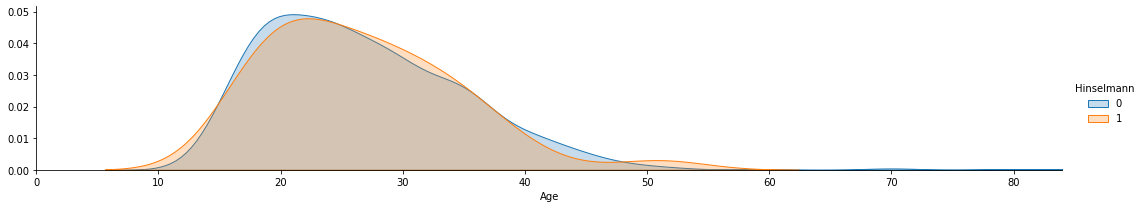

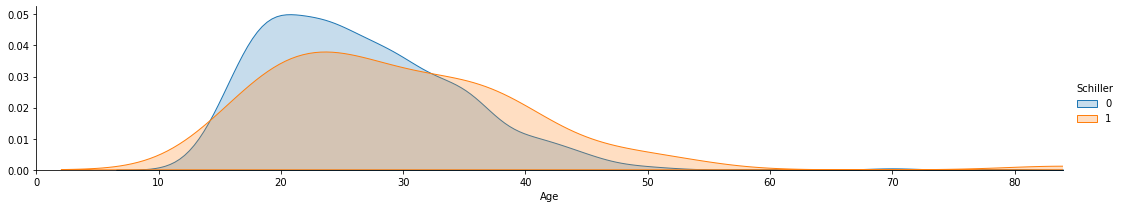

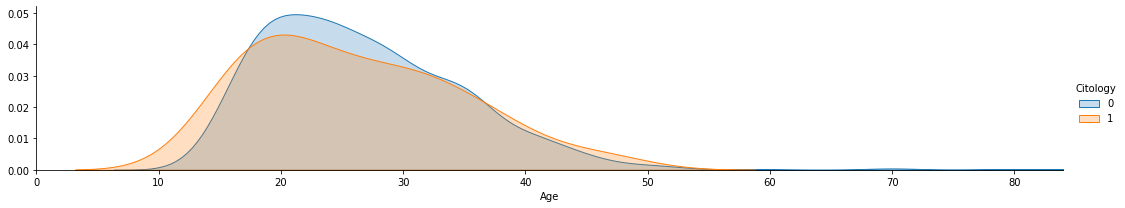

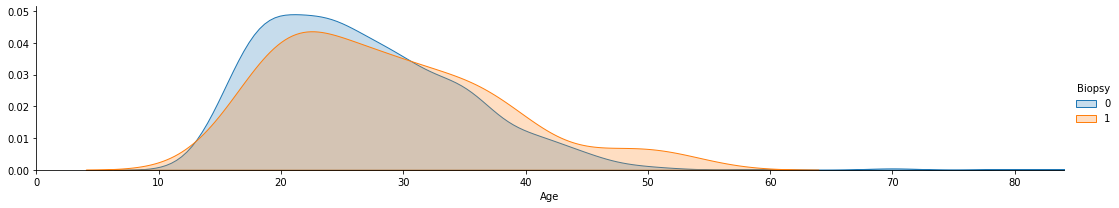

In [92]:
for feature in medical_tests:

 as_fig = sns.FacetGrid(pre_df,hue=feature,aspect=5)
 as_fig.map(sns.kdeplot,'Age',shade=True)
 oldest = pre_df['Age'].max()
 as_fig.set(xlim=(0,oldest))
 as_fig.add_legend()

/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


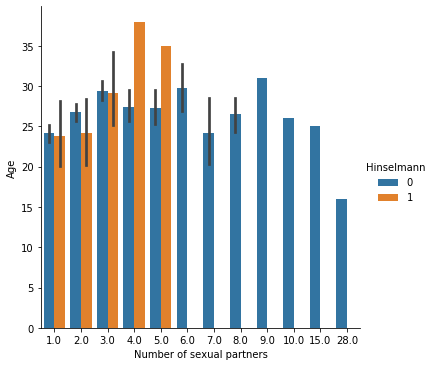

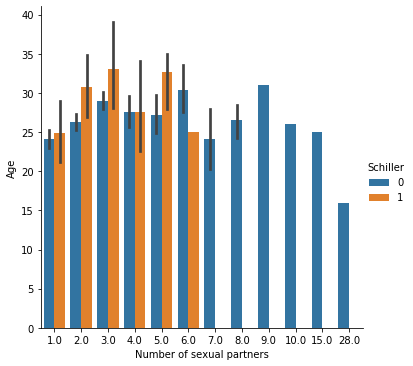

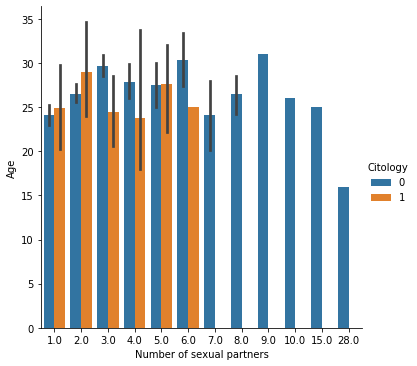

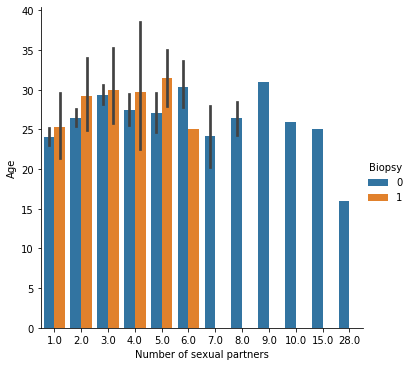

In [96]:
for feature in medical_tests:
  
  print(sns.factorplot(x='Number of sexual partners',y='Age',hue=feature,data=pre_df,kind='bar'))

KeyError: None

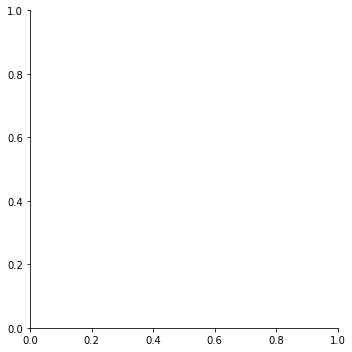

In [102]:
for feature in medical_tests:
    print(sns.lmplot(x='Age', hue=feature,data=pre_df))

## 1c. Data wrangling

In [56]:
def wrangle(df):

    # drop some cols to prevent leakage because the columns are POSSIBLY 
    # additional target variables
    drop_cols = ['Hinselmann', 'Schiller', 'Citology']
    df.drop(columns=drop_cols, inplace=True)
    
    #fill nan 
    df = df.fillna(df.mean().to_dict())

    return df

In [57]:
df = wrangle(pre_df)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [59]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy
0,18,4.0,15.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,15,1.0,14.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,34,1.0,16.9953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,52,5.0,16.0000,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
4,46,3.0,21.0000,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [60]:
df['Biopsy'].value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [61]:
1-55/858

0.9358974358974359

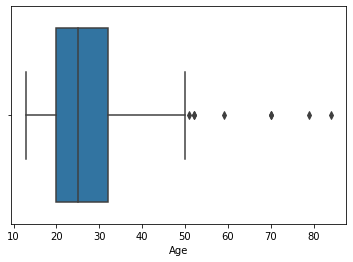

In [62]:
sns.boxplot(x=df["Age"])

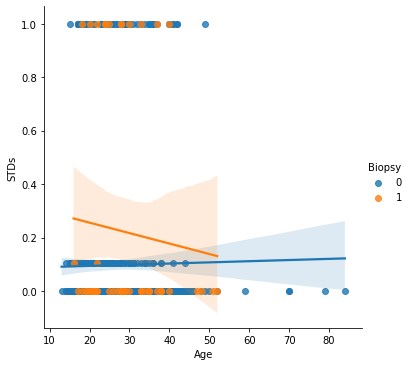

In [63]:
sns.lmplot(x="Age", y="STDs", hue="Biopsy", data=df)
# Chart shows that STD alone doesnt explain malignancy

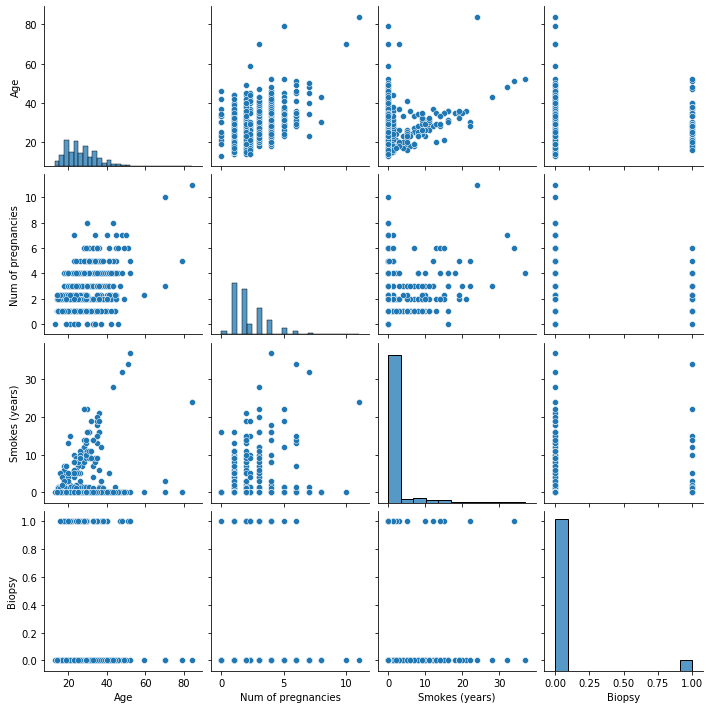

In [64]:
sns.pairplot(
    df,
    x_vars=["Age", "Num of pregnancies", "Smokes (years)", "Biopsy"],
    y_vars=["Age", "Num of pregnancies", "Smokes (years)", "Biopsy"],
)

## 2. Split the data

In [65]:
target = 'Biopsy'
X = df.drop(columns=target)
y = df[target]

In [66]:
# Split the data into Test/Train/Validation sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=30)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=30)

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

# with SMOTE
from imblearn.combine import SMOTETomek
cc = SMOTETomek(random_state=2019)
X_train, y_train = cc.fit_resample(X_train, y_train)

## 3. Establish the Baseline

In [67]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5


## 4. Build models

### i. Logistic Regression

In [68]:
# Logistic Regression
model_lg = make_pipeline(
            SimpleImputer(strategy='mean'),
            LogisticRegression(class_weight="balanced")
            )

model_lg.fit(X_train, y_train);

/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### ii. XGBoost Model

In [69]:
model_xgb = make_pipeline(XGBClassifier(scale_pos_weight = 803/55,
                                         n_estimators=100,
                                          max_depth=10,
                                          learning_rate=1e-3,
                                          n_jobs=10))

model_xgb.fit(X_train, y_train);

[14:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### iii. Random Forest Model

In [70]:
# Random forest
model_rf = make_pipeline(
        RandomForestClassifier(n_estimators=25,
                               n_jobs=-1,
                               random_state=42)
        )

model_rf.fit(X_train, y_train);

## 5. Check the metrics

In [71]:
# LOGISTIC REGRESSION
lg_train_acc = model_lg.score(X_train, y_train)
lg_val_acc = model_lg.score(X_val, y_val)
print('Logistic regression Training Accuracy Score:', lg_train_acc)
print('Logistic regression Validation Accuracy Score:', lg_val_acc)

# XG BOOST
xgb_train_acc = model_xgb.score(X_train, y_train)
xgb_val_acc = model_xgb.score(X_val, y_val)
print('XGB Training Accuracy Score:', xgb_train_acc)
print('XGB Validation Accuracy Score:', xgb_val_acc)

# RANDOM FOREST
rf_train_acc = model_rf.score(X_train, y_train)
rf_val_acc = model_rf.score(X_val, y_val)
print('Random Forest Training Accuracy Score:', rf_train_acc)
print('Random Forest Validation Accuracy Score:', rf_val_acc)

Logistic regression Training Accuracy Score: 0.6374407582938388
Logistic regression Validation Accuracy Score: 0.7209302325581395
XGB Training Accuracy Score: 0.7401263823064771
XGB Validation Accuracy Score: 0.4476744186046512
Random Forest Training Accuracy Score: 0.9984202211690363
Random Forest Validation Accuracy Score: 0.9127906976744186


## 6. Select and tune the model

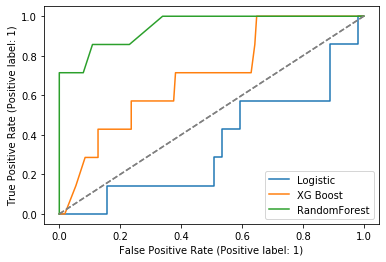

In [72]:
# Training and Validation Accuracy scores above suggest 
# that We select the Random forest model as our preferred model
# So I plot the ROC curve to get further insights into this choice

lr = plot_roc_curve(model_lg, X_test, y_test, label='Logistic')
xg = plot_roc_curve(model_xgb, X_test, y_test, ax=lr.ax_, label='XG Boost')
rf = plot_roc_curve(model_rf, X_test, y_test, ax=lr.ax_, label='RandomForest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

# The plot suggests that Random Forest is a good choice for predicting Malignant cancer.

In [73]:
lg_recall_score = recall_score(y_val, model_lg.predict(X_val))
print("Logistic regression recall score", lg_roc_auc_score)
xg_recall_score = recall_score(y_val, model_xgb.predict(X_val))
print("XG Boost recall score", xg_roc_auc_score)
rf_recall_score = recall_score(y_val, model_rf.predict(X_val))
print("Random Forest recall score", rf_roc_auc_score)

Logistic regression recall score 0.36539060068471835
XG Boost recall score 0.582477435418612
Random Forest recall score 0.5188297541238718


In [74]:
# param_grid = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'randomforestclassifier__max_depth': range(5,40,5),
#     'randomforestclassifier__n_estimators': range(25, 125, 25)
# }

# model_rs = RandomizedSearchCV(
#     model_rf, 
#     param_distributions=param_grid,
#     n_iter=3,
#     cv=None,
#     n_jobs=-1,
#     verbose=1
# )

# model_rs.fit(X_train, y_train)

In [75]:
# dir(model_lg)

## 7. Communicate Results

In [76]:
y_val.value_counts()

0    161
1     11
Name: Biopsy, dtype: int64

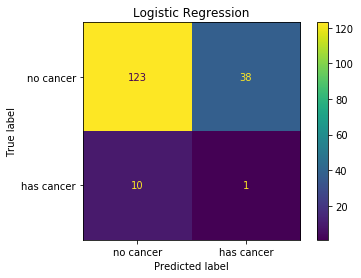

In [77]:
# plot confusion matrix using LogisticRegression
disp = plot_confusion_matrix(
    model_lg,
    X_val, # USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['no cancer', 'has cancer']
);
disp.ax_.set_title("Logistic Regression")
print(disp);

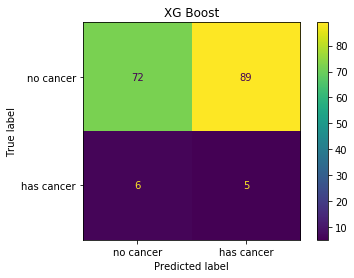

In [78]:
# plot confusion matrix using XG Boost
disp = plot_confusion_matrix(
    model_xgb,
    X_val, # USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['no cancer', 'has cancer']
);
disp.ax_.set_title("XG Boost")
print(disp);

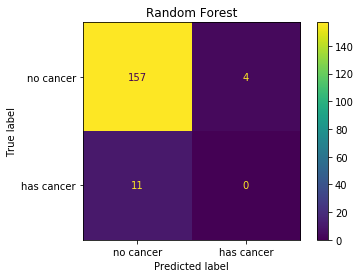

In [79]:
# plot confusion matrix using Random Forest
disp = plot_confusion_matrix(
    model_rf,
    X_val, # USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['no cancer', 'has cancer']
);
disp.ax_.set_title("Random Forest")
print(disp);

In [80]:
# dir(model_lg)

In [81]:
# importances = model_lg.named_steps['logisticregression'].feature_importances_
# features = model_lg.named_steps['ordinalencoder'].get_feature_names()
# feat_imp = pd.Series(importances, index=features).sort_values()
# feat_imp.tail(20).plot(kind='barh')
# plt.xlabel('Reduction in Gini Impurity');

Text(0, 0.5, 'feature name')

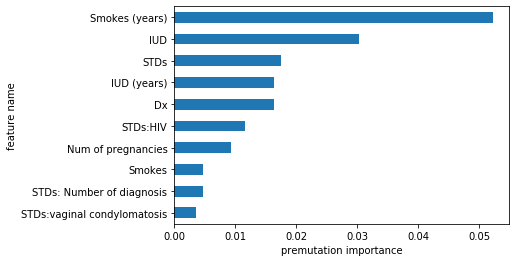

In [82]:
# permutation importance Logistic REgression
per_imp = permutation_importance(model_lg, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-1, 
                                 random_state=42 )
pd.Series(per_imp['importances_mean'], index=X_val.columns).sort_values().tail(10).plot(kind='barh')
plt.xlabel('premutation importance')
plt.ylabel('feature name')

Text(0, 0.5, 'feature name')

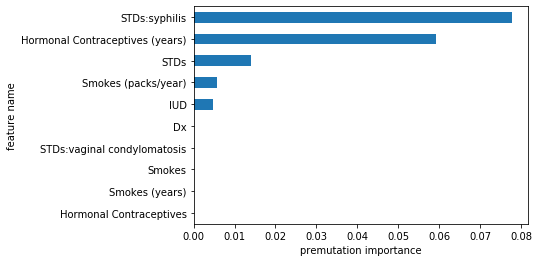

In [83]:
# permutation importance XG Boost
per_imp = permutation_importance(model_xgb, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-1, 
                                 random_state=42 )
pd.Series(per_imp['importances_mean'], index=X_val.columns).sort_values().tail(10).plot(kind='barh')
plt.xlabel('premutation importance')
plt.ylabel('feature name')

Text(0, 0.5, 'feature name')

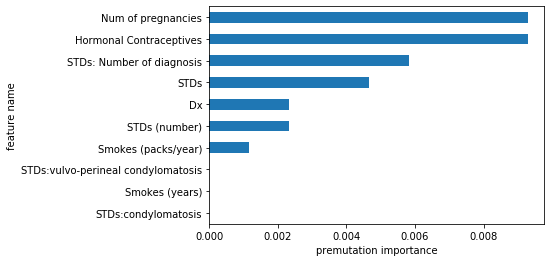

In [84]:
# permutation importance Random Fores
per_imp = permutation_importance(model_rf, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-1, 
                                 random_state=42 )
pd.Series(per_imp['importances_mean'], index=X_val.columns).sort_values().tail(10).plot(kind='barh')
plt.xlabel('premutation importance')
plt.ylabel('feature name')

In [85]:
# from pdpbox.pdp import pdp_isolate, pdp_plot
# feature = 'Age'

# isolated = pdp_isolate(model=model_rf,
#            dataset=X_val, 
#            model_features=X_val.columns,
#            feature= feature)

# pdp_plot(isolated,feature_name=feature,plot_lines=True, frac_to_plot=0.01)